In [1]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [1]:
import PySimpleGUI as sg    
from pykat import finesse
from pykat.commands import * 
import pykat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
import math
import datetime

sg.theme('Default1')

def collapse(layout, key):
    """
    Helper function that creates a Column that can be later made hidden, thus appearing "collapsed"
    :param layout: The layout for the section
    :param key: Key used to make this seciton visible / invisible
    :return: A pinned column that can be placed directly into your layout
    :rtype: sg.pin
    """
    return sg.pin(sg.Column(layout, key=key))

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
# やること

# DRFPMIのタブをまだ作成していないので、GUIのタブでMIやDRFPMIを選択するとクラッシュするので注意
# overplotした時にo_I,o_Q,I,Qで色の分け方を共通にする　IとQの色の分け方をoverplotした時にも同じ色になるようにする
# ひとまずPRFPMIのタブを作成したが、動作するようなのでDRFPMIなどのタブも作成する
# PRFPMIのタブのDOFがまだできていないので作成する

In [3]:
# やったこと

# katファイルを出力する時に作成した日時を挿入する
# PRFPMIでもkatファイルとoutputをtxtで出力できるか確認する
# outputの結果をtxtで出力する、pd1とpd2のところがまだできていない
# legendのサイズが自動的に変えられるようにする 実装しなくて良い
# 図を拡大したりするボタン
# finesseの結果をmatplotlibでplotするところ、複雑になっているので前のバージョンに戻す
# event == FPMI のところ関数にしたら全部のタブで共通にできそう
# l_ いらない
# katファイルを作成した時刻をkatファイルに書き込む dt_now
# demod_1 を選んでからtransferfunctionを選び、もう一度sweepを選んだ時demod_1が選択されているが、追加のオプションのセクションが開いていない
# GUIのところ引数にリストで渡したウィンドウだけ表示するようにする
# 選択したpdのリストは表示するところで再利用する 終わった
# 選択したpdをリストで渡して選択した物だけがkatファイルに書き込まれるようにする
# windowを表示/非表示にする部分を関数にした
# pdを選んだ時に何も選ばれていない時エラーが出るはずなので直す
# どのタブでも対応できるようにしたつもりだけど、タブを切り替えてもvalues["kPRFPMI_..."]みたいなやつが残るからこのやり方だとダメかもしれない
# make_katpdのphaseのところFPMIにしか対応していないのでこれを直す
# make_katpdのところ複数タブに対応していない

In [4]:
def generate_kat(pds, dic_advanced_setting, selected_interferometer):
    # pdsの名前
    ##############################
    ### get variables from GUI ###
    ##############################

    ### Extra Settings ###
    laser_power = dic_advanced_setting["laser_power"]#source laser power
    
    ### DoF ###
    #  
    # (yuzu) pick up DoF (CARM / DARM / BS) from GUI
    # 
    dof = dic_advanced_setting["dof"]#CARM DARM BS
    
    ### sweep_power/sweep_demod_1/transferfunction_power/transferfunction_demod_2 ###
    type_of_pd_signal = dic_advanced_setting["type_of_pd_signal"]#(sweep_mode)
    ### xaxis/yaxis setting ###
    x_plotscale = dic_advanced_setting["x_plotscale"]#str
    xaxis_range_beg = dic_advanced_setting["xaxis_range_beg"]#str
    xaxis_range_end = dic_advanced_setting["xaxis_range_end"]#str
    y_plotscale = dic_advanced_setting["y_plotscale"]#str
    if x_plotscale=='linear':
        x_plotscale = 'lin'
    if y_plotscale=='linear':
        y_plotscale = 'lin'
    samplingnum = dic_advanced_setting["samplingnum"]

    ######################
    ### INF components ###
    ######################
    #
    # Prepare common (fixed for KAGRA) setting for kat file 
    # PRFPMIとかはこの部分とDOFの種類だけ変わる
    # 
    input_finesse = create_input_finesse(dic_advanced_setting, selected_interferometer)

    ## pds ##
    input_finesse += """
## PDs ##
"""
    for pd in pds:
        input_finesse += """%s""" % pd

    ### sweep ###
    if(type_of_pd_signal=="sweep_power" or type_of_pd_signal=="sweep_demod_1"):
        ### DoF ###
        if(dof=="DARM"):
            input_finesse += """

# DARM scan
xaxis ETMX phi %s %s %s %s
put* ETMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)

        elif(dof=="CARM"):
            input_finesse += """

# CARM scan
#(koyama) xaxis*
#initial
# m ITMX 0.996 0.004 0 nx1 nx2
xaxis ETMX phi %s %s %s %s
put* ETMY phi $x1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)

        elif(dof=="BS"):
            input_finesse += """

# BS scan
#
#(koyama) original vergion log kokeyamasan uses xaxis*
# select xaxis plotscale "log" cause an error with xaxis*
# m ITMX 0.996 0.004 0 nx1 nx2 
# since the config are above, I think it doesnt cause any problem about the correctness of the result
# 

xaxis ITMX phi %s %s %s %s
put* ITMY phi $mx1
put* ETMX phi $x1
put* ETMY phi $mx1
yaxis abs
            """ % (x_plotscale, xaxis_range_beg,xaxis_range_end, samplingnum)
        else:
            pass

    ### transfer function ###
    if(type_of_pd_signal=="transferfunction_power" or type_of_pd_signal=="transferfunction_demod_2"):   
        ### DoF ###
        if(dof=="DARM"):
            input_finesse += """

## DARM ###
fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs:deg
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)

        elif(dof=="CARM"):
            input_finesse += """

## CARM ###
fsig sig1 ETMX 10 0
fsig sig1 ETMY 10 0
xaxis sig1 f %s %s %s %s
yaxis lin abs:deg
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)


        elif(dof=="BS"):
            input_finesse += """

## BS ###
fsig sig1 ETMX 10 0
fsig sig1 ITMX 10 0
fsig sig1 ETMY 10 180
fsig sig1 ITMY 10 180
xaxis sig1 f %s %s %s %s
yaxis lin abs
            """ % (x_plotscale, xaxis_range_beg, xaxis_range_end, samplingnum)
        else:
            pass

    code = input_finesse
    print(code)
    return code

In [5]:
# 動作するようなので、DRFPMIなども追加する
def create_input_finesse(dic_advanced_setting, selected_interferometer): 
    laser_power = dic_advanced_setting["laser_power"]
    
    if selected_interferometer=="FPMI":
        input_finesse = """

### FPMI

const fsb1 16.881M
const fsb2 45.0159M

# Input optics
l I_fsb1 %s 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 16.881M 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 45.0159M 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

# Michelson
bs bs1 0.5 0.5 0 45 REFL n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1


# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.99995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.99995 5e-06 90 ny3 nTMSY

        """ % (laser_power)
        
    elif selected_interferometer=="PRFPMI":
        input_finesse = """
# PRFPMI

# ======== Constants ========================
const fsb1 16.881M
const fsb2 45.0159M
const mfsb1 -16.881M
const mfsb2 -45.0159M
const a 0.686

# ======== Input optics =====================
l i1 %s 0 n0
s s_eo0 0 n0 n_eo1
mod eom1 $fsb1 0.3 1 pm n_eo1 n_eo2
s s_eo1 0 n_eo2 n_eo3
mod eom2 $fsb2 0.3 1 pm n_eo3 n_eo4
s s_eo2 0 n_eo4 REFL

## ======= PRC each mirror loss 45ppm =======
m1 PRM 0.1 0 0 REFL npr1
s sLpr1 14.7615 npr1 npr2
bs1 PR2 500e-6 0 0 $a npr3 npr2 nPOP nPOP2
s sLpr2 11.0661 npr3 npr4
#bs1 PR3 50e-6 0 0 $a dump dump npr4 npr5
bs1 PR3 0 0 0 $a npr4 npr5 dump dump 
s sLpr3 15.7638 npr5 npr6

# Michelson
bs bs1 0.5 0.5 0 45 npr6 n2 n3 AS
s lx 26.6649 n3 nx1
s ly 23.3351 n2 ny1

# X arm
m ITMX 0.996 0.004 0 nx1 nx2
s sx1 3000 nx2 nx3
m ETMX 0.999995 5e-06 0 nx3 nTMSX

# Y arm
m ITMY 0.996 0.004 90 ny1 ny2
s sy1 3000 ny2 ny3
m ETMY 0.999995 5e-06 90 ny3 nTMSY
        """%(laser_power)
    
    return input_finesse

In [6]:
#　保存されるときの名前が勝手に固有の名前が生成される
# DARM FPMI laserpower タイトルでどの設定かわかる名前
# 画像の保存のチェックボックス
# 保存場所がどこかポップアップで表示

In [7]:
# k_: key
# inf_c: kcommon_
# inf_m_: kmi_
# inf_f_: kfpmi_
# inf_p_: kprfpmi_
# inf_d_: kdrfpmi_
# 右のほうがいいかも

In [26]:
### タブを増やすときに追加する ###
all_interferometers = ["FPMI", "PRFPMI"]# 使わなかった
# all_portss
all_ports = ["REFL", "AS", "nTMSX", "nTMSY", 
                "n2", "n3", # n1=REFL, n4=AS
                "nx1", "nx2", "nx3",
                "ny1", "ny2", "ny3","POP"]
all_pdtypes = ["pd0", "pd1", "pd2"]
all_demod_phases = ["overplot_IQ", "Iphase", "Qphase"]
all_demod_freqs = ["fsb1", "fsb2"]

# まとめて渡す
# まとめなくて良いかも
# 
dic_all_keycomponents = {
            'all_ports':all_ports,
            'all_pdtypes':all_pdtypes,
            'all_demod_phases':all_demod_phases,
            'all_demod_freqs':all_demod_freqs,
            }

# ここから下何個か関数を作ったが、k%s_event%selectedtabなどの方法でいろんなタブに対応させることが出来そうなので、一度しか使っていないものは関数にしなくても良いと思う

def make_katpd(values, dic_all_keycomponents, selected_tab, type_of_pd_signal):   # pd1_fsb1_Iphase_REFLの順でpdの名前を作る

    # どのタブでも共通にするために関数でないといけない
    # fpmi_pd1_I_fsb1_REFL のようなpdの名前を作成してリストにする
    # このリストを使ってout.plotの部分を共通にしたり、選択したpdだけがkatファイルに追加されるようにする
    # pd1_I1_REFL のようなpdの名前を作成してリストにする
    # このリストを使ってout.plotの部分を共通にしたり、選択したpdだけがkatファイルに追加されるようにする
    all_ports = dic_all_keycomponents["all_ports"]
    all_pdtypes = dic_all_keycomponents["all_pdtypes"]
    all_demod_phases = dic_all_keycomponents["all_demod_phases"]
    all_demod_freqs = dic_all_keycomponents["all_demod_freqs"]
    port_trues = []
    pdnames = []
    bool_overplots = []
    pds = []
    demod_phase_gui = values["k%s_pd1_demod_phase"%selected_tab]#str
    if(type_of_pd_signal=="transferfunction_demod_2"):
        demod_phase_gui  = values["k%s_pd2_demod_phase"%selected_tab]#str
    
    interferometer = selected_tab
    
    for port in all_ports:
        port_name = "%s_%s" % (interferometer, port)
        if "k"+port_name in values:# valueにはGUIのチェックボックスのkFPMI_REFLなどが入っている
            if(values["k"+port_name]):
                port_trues.append(port)
    if len(port_trues)==0:
        port_trues.append("REFL")

    if type_of_pd_signal=="sweep_power" or type_of_pd_signal=="transferfunction_power":
        for port in port_trues:
            pdnames.append("pd0_%s"%(port))
            bool_overplots.append(False)
            pds.append("""
pd0 pd0_%s %s""" % (port, port)
            )
    else:
        # 短くなりそう　インデント多い
        for pdtype in all_pdtypes:
            for port in port_trues:
                for freq in all_demod_freqs:
                    for phase in all_demod_phases:
                        key = interferometer+"_%s_%s_%s" % (pdtype, phase, freq)#先頭にkを足すとGUIでのkeyになる
                        if ("k"+key in values and values["k"+key]):
                            if phase=="overplot_IQ":
                                Isoverplot = True
                                names = ["%s_Iphase_%s" % (pdtype, freq), "%s_Qphase_%s" % (pdtype, freq)]#names -> pdname_head
                                demod_phase = [str(0+float(demod_phase_gui)), str(90+float(demod_phase_gui))]
                            else:
                                Isoverplot = False
                                names = ["%s_%s_%s" % (pdtype, phase, freq)]
                            for n in range(len(names)):
                                bool_overplots.append(Isoverplot)
                                pdnames.append("%s_%s" % (names[n], port))
                                if phase=="Iphase":
                                    demod_phase = [str(0+float(demod_phase_gui))]#str
                                elif phase=="Qphase":
                                    demod_phase = [str(90+float(demod_phase_gui))]#str
                                else:
                                    pass
                                if type_of_pd_signal=="sweep_demod_1":
                                    pds.append("""
pd1 %s_%s $%s %s %s"""% (names[n], port, freq, demod_phase[n], port))
                                else:
                                    pds.append("""
pd2 %s_%s $%s %s 10 %s
put %s_%s f2 $x1
"""% (names[n], port, freq, demod_phase[n], port, names[n], port))

    # katファイルに書き込むとき重複すると読み込んでくれないから重複をなくしている
    # set()を使うと順番が変わるから、このやり方を使っている
    uniqued = []
    for x in pds:
        if not x in uniqued:
            uniqued.append(x)
    pds = uniqued
    
    # もし何も選択していなかった時にエラーが出ないようにここで設定する
    # ちょっと長い
    if len(pdnames)==0:
        demod_phase = str(0+float(demod_phase_gui))#str
        bool_overplots = [False]
        for port in port_trues:
            if (type_of_pd_signal == 'sweep_power' or type_of_pd_signal == 'transferfunction_power'):
                bool_overplots.append(False)
                pdnames.append("pd0_%s"%port)
                pds.append("""
pd0 pd0_%s %s
"""%(port,port))
            elif (type_of_pd_signal=='sweep_demod_1'):
                bool_overplots.append(False)
                pdnames.append("""pd1_Iphase_fsb1_%s"""%port)
                pds.append("""
pd1 pd1_Iphase_fsb1_%s $fsb1 %s %s
"""%(port, demod_phase, port))
            else:
                bool_overplots.append(False)
                pdnames.append("pd2_Iphase_fsb1_%s"%port)
                pds.append("""
pd2 pd2_Iphase_fsb1_%s $fsb1 %s 10 %s 
put pd2_Iphase_fsb1_%s f2 $x1"""%(port, demod_phase, port, port))

    return port_trues, pds, pdnames, bool_overplots

def visible_section(l_k_section_bool, selected_tab):
    l_k_allsection_bool = []
    for interferometer in all_interferometers:
        l_k_allsection_bool += ["k%s_issweep"%interferometer, "k%s_istransfunc"%interferometer, "k%s_isscan"%interferometer, "k%s_isdemod_1"%interferometer, "k%s_istransferfunction_power"%interferometer, "k%s_istransferfunction_demod_2"%interferometer]
    for key in l_k_allsection_bool:
        values[key] = False
    for k_section_bool in l_k_section_bool:
        values[k_section_bool] = True
        window[k_section_bool].update(True)

def visible_guiobject(l_GUIwindow, selected_tab):
    # これ入れると設定を切り替えるごとに画像が消えるからコメントアウトした
    # "k%s_drawing_normalsize"%interferometer, "k%s_drawing_largesize"%interferometer, 
    l_k_allGUIwindow = []
    for interferometer in all_interferometers:
        l_k_allGUIwindow += ["k%s_sweep_section_how_simulate"%interferometer, "k%s_transferfunction_section_how_simulate"%interferometer, "k%s_pd0_setting_section"%interferometer, "k%s_pd1_setting_section"%interferometer, "k%s_pd2_section_power"%interferometer, "k%s_pd2_setting_section"%interferometer]
    for key in l_k_allGUIwindow:
        window[key].update(visible=False)
    for windowkey in l_GUIwindow:
        window[windowkey].update(visible=True)

# タブごとに共通にするつもりなので関数にした
def change_GUI_plotscale(k_axis_plotscale):
    l_k_allplotscale = ["k_inf_c_xaxis_lin", "k_inf_c_xaxis_log", "k_inf_c_yaxis_lin", "k_inf_c_yaxis_log"]
    for key in l_k_allplotscale:
        values[key] = False
    values[k_axis_plotscale] = True
    window[k_axis_plotscale].update(True)

# タブごとに共通にするつもりなので関数にした
def change_GUI_xplotscale_defaultvalue(value_beg, value_end):
    window['k_inf_c_xaxis_range_beg'].update(value_beg)
    window['k_inf_c_xaxis_range_end'].update(value_end)

##################################    
#section setting pd0/pd1/pd2
##################################
# FPMI
kFPMI_section_pd0 = [

            ]
kFPMI_section_pd1 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I_fsb1 and Q_fsb1 overplot)', size=(30, 1), key='kFPMI_pd1_overplot_IQ_fsb1'),
            sg.Checkbox('I_fsb2 and Q_fsb2 overplot)', size=(30, 1), key='kFPMI_pd1_overplot_IQ_fsb2')],
            [sg.Checkbox('I_fsb1(in_phase f1)', size=(25, 1), key='kFPMI_pd1_Iphase_fsb1'),
            sg.Checkbox('Q_fsb1(quadrature_phase f1)', size=(30, 1), key='kFPMI_pd1_Qphase_fsb1'),
            sg.Checkbox('I_fsb2(in_phase f2)', size=(25, 1), key='kFPMI_pd1_Iphase_fsb2'),
            sg.Checkbox('Q_fsb2(quadrature_phase f2)', size=(30, 1), key='kFPMI_pd1_Qphase_fsb2')],
            [sg.Text('Demodulation_frequency'),sg.Input(key='kFPMI_pd1_demodfreq', default_text='0', enable_events=True)],
            [sg.Text('Demodulation_phase'),sg.Input(key='kFPMI_pd1_demod_phase', default_text='0', enable_events=True)]
]
kFPMI_section_pd2 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I_fsb1 and Q_fsb1 overplot)', size=(30, 1), default=False, key='kFPMI_pd2_overplot_IQ_fsb1'),
            sg.Checkbox('I_fsb2 and Q_fsb2 overplot)', size=(30, 1), key='kFPMI_pd2_overplot_IQ_fsb2')],
            [sg.Checkbox('I_fsb1(in_phase f1)', size=(25, 1), key='kFPMI_pd2_Iphase_fsb1'),
            sg.Checkbox('Q_fsb1(quadrature_phase f1)', size=(30, 1), key='kFPMI_pd2_Qphase_fsb1'),
            sg.Checkbox('I_fsb2(in_phase f2)', size=(25, 1), key='kFPMI_pd2_Iphase_fsb2'),
            sg.Checkbox('Q_fsb2(quadrature_phase f2)', size=(30, 1), key='kFPMI_pd2_Qphase_fsb2'),
            ],
            #[sg.Text('mixer1 demodulation freq (0, 100, max)'), sg.Input(key='kFPMI_pd2_mixer1_demodfreq', default_text='0', enable_events=True)],
            [sg.Text('Demodulation_phase'),sg.Input(key='kFPMI_pd2_demod_phase', default_text='0', enable_events=True)]
]
kFPMI_pd2_section_power = [

            ]
kFPMI_sweep_section_how_simulate = [
            [sg.Radio('Power(pd0)', 'RADIO1', default=True, size=(20,1), key='kFPMI_isscan', enable_events=True),# "%s_%s"
             sg.Radio('Demod_once(pd1)','RADIO1', default=False, size=(20,1), key='kFPMI_isdemod_1', enable_events=True)],
            ### pd0_setting_section
            [collapse(kFPMI_section_pd0, 'kFPMI_pd0_setting_section')],
            ### pd1_settnig_section
            [collapse(kFPMI_section_pd1, 'kFPMI_pd1_setting_section')]
            ]
kFPMI_transferfunction_section_how_simulate = [
    [sg.Radio('Power(pd0)', 'pd2_RADIO', default=True, size=(20,1), key='kFPMI_istransferfunction_power', enable_events=True),
    sg.Radio('Demod(pd2)','pd2_RADIO', default=False, size=(20,1), key='kFPMI_istransferfunction_demod_2', enable_events=True)],
    #
    #sg.Radio('altanative way','pd2_RADIO', default=False, size=(20,1), key='kFPMI_istransferfunction_alt', enable_events=True)
    ### pd2_setting_section
    [collapse(kFPMI_pd2_section_power, 'kFPMI_pd2_section_power')],
    ### pd2_setting_section
    [collapse(kFPMI_section_pd2, 'kFPMI_pd2_setting_section')]
]

# PRFPMI
kPRFPMI_section_pd0 = [

            ]
kPRFPMI_section_pd1 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I_fsb1 and Q_fsb1 overplot)', size=(30, 1), key='kPRFPMI_pd1_overplot_IQ_fsb1'),
            sg.Checkbox('I_fsb2 and Q_fsb2 overplot)', size=(30, 1), key='kPRFPMI_pd1_overplot_IQ_fsb2')],
            [sg.Checkbox('I_fsb1(in_phase f1)', size=(25, 1), key='kPRFPMI_pd1_Iphase_fsb1'),
            sg.Checkbox('Q_fsb1(quadrature_phase f1)', size=(30, 1), key='kPRFPMI_pd1_Qphase_fsb1'),
            sg.Checkbox('I_fsb2(in_phase f2)', size=(25, 1), key='kPRFPMI_pd1_Iphase_fsb2'),
            sg.Checkbox('Q_fsb2(quadrature_phase f2)', size=(30, 1), key='kPRFPMI_pd1_Qphase_fsb2')],
            [sg.Text('Demodulation_frequency'),sg.Input(key='kPRFPMI_pd1_demodfreq', default_text='0', enable_events=True)],
            [sg.Text('Demodulation_phase'),sg.Input(key='kPRFPMI_pd1_demod_phase', default_text='0', enable_events=True)]
]
kPRFPMI_section_pd2 = [
            [sg.Text('Which phase to plot?')],
            [sg.Checkbox('I_fsb1 and Q_fsb1 overplot)', size=(30, 1), default=False, key='kPRFPMI_pd2_overplot_IQ_fsb1'),
            sg.Checkbox('I_fsb2 and Q_fsb2 overplot)', size=(30, 1), key='kPRFPMI_pd2_overplot_IQ_fsb2')],
            [sg.Checkbox('I_fsb1(in_phase f1)', size=(25, 1), key='kPRFPMI_pd2_Iphase_fsb1'),
            sg.Checkbox('Q_fsb1(quadrature_phase f1)', size=(30, 1), key='kPRFPMI_pd2_Qphase_fsb1'),
            sg.Checkbox('I_fsb2(in_phase f2)', size=(25, 1), key='kPRFPMI_pd2_Iphase_fsb2'),
            sg.Checkbox('Q_fsb2(quadrature_phase f2)', size=(30, 1), key='kPRFPMI_pd2_Qphase_fsb2'),
            ],
            #[sg.Text('mixer1 demodulation freq (0, 100, max)'), sg.Input(key='kPRFPMI_pd2_mixer1_demodfreq', default_text='0', enable_events=True)],
            [sg.Text('Demodulation_phase'),sg.Input(key='kPRFPMI_pd2_demod_phase', default_text='0', enable_events=True)]
]
kPRFPMI_pd2_section_power = [

            ]
kPRFPMI_sweep_section_how_simulate = [
            [sg.Radio('Power(pd0)', 'RADIO1', default=True, size=(20,1), key='kPRFPMI_isscan', enable_events=True),# "%s_%s"
             sg.Radio('Demod_once(pd1)','RADIO1', default=False, size=(20,1), key='kPRFPMI_isdemod_1', enable_events=True)],
            ### pd0_setting_section
            [collapse(kPRFPMI_section_pd0, 'kPRFPMI_pd0_setting_section')],
            ### pd1_settnig_section
            [collapse(kPRFPMI_section_pd1, 'kPRFPMI_pd1_setting_section')]
            ]
kPRFPMI_transferfunction_section_how_simulate = [
    [sg.Radio('Power(pd0)', 'pd2_RADIO', default=True, size=(20,1), key='kPRFPMI_istransferfunction_power', enable_events=True),
    sg.Radio('Demod(pd2)','pd2_RADIO', default=False, size=(20,1), key='kPRFPMI_istransferfunction_demod_2', enable_events=True)],
    #
    #sg.Radio('altanative way','pd2_RADIO', default=False, size=(20,1), key='kPRFPMI_istransferfunction_alt', enable_events=True)
    ### pd2_setting_section
    [collapse(kPRFPMI_pd2_section_power, 'kPRFPMI_pd2_section_power')],
    ### pd2_setting_section
    [collapse(kPRFPMI_section_pd2, 'kPRFPMI_pd2_setting_section')]
]

##################################    
# drawing 
##################################
# FPMI
kFPMI_drawing_normalsize = [
                [sg.Image('./Fabry_Perot_MI_eom_drawing.png', key='kFPMI_imageContainer', size=(400,300))]#size=(800,600)
]
kFPMI_drawing_largesize = [
                [sg.Image('./Fabry_Perot_MI_eom_drawing.png', key='kFPMI_imageContainer2', size=(800,600))]#size=(800,600)
]

# PRFPMI
kPRFPMI_drawing_normalsize = [
                [sg.Image('./Fabry_Perot_MI_eom_drawing.png', key='kPRFPMI_imageContainer', size=(400,300))]#size=(800,600)
]
kPRFPMI_drawing_largesize = [
                [sg.Image('./Fabry_Perot_MI_eom_drawing.png', key='kPRFPMI_imageContainer2', size=(800,600))]#size=(800,600)
]

##################################    
#TAB select FPMI/PRFPMI/DRFPMI
##################################
#kFPMI_tab
kFPMI_layout = [
                [collapse(kFPMI_drawing_normalsize, 'kFPMI_drawing_normalsize')],
                [collapse(kFPMI_drawing_largesize, 'kFPMI_drawing_largesize')],
                ### RADIO BOX pd0/pd1/pd2
                [sg.Text('1. Select Sweep or Transfer function ')],
                [sg.Radio('Sweep', 'HOW_SIMULATE01', default=True, size=(10,1), key='kFPMI_issweep', enable_events=True),
                 sg.Radio('Transfer function(pd2)', 'HOW_SIMULATE01', default=False, size=(25,1), key='kFPMI_istransfunc', enable_events=True)],
                ### RADIO BOX pd0/pd1/pd2
                [collapse(kFPMI_sweep_section_how_simulate, 'kFPMI_sweep_section_how_simulate')],
                ### RADIO BOX pd0/pd1/pd2
                [collapse(kFPMI_transferfunction_section_how_simulate, 'kFPMI_transferfunction_section_how_simulate')],
                [sg.Text('2. Select which Dof to move')],
                [sg.Text('　　DoF'),sg.Combo(('DARM', 'CARM', 'BS'), default_value='DARM', size=(20, 1), key='kFPMI_dof')], #RADIOBOXに変える
                #[sg.Text('　　DoF'), sg.Spin(values=('DARM', 'CARM', 'BS'), initial_value='DARM', key="kFPMI_dof", size=(10,2))],     
                ## PDs checkbox
                [sg.Text('3. Select port (see the top figure)')],#図と関連あるとかく
                [sg.Checkbox('REFL', size=(10, 1), default=True, key='kFPMI_REFL'),sg.Checkbox('AS', size=(5, 1),default=True, key='kFPMI_AS'),
                sg.Checkbox('nTMSY', size=(10, 1), default=True,key='kFPMI_nTMSY'),sg.Checkbox('nTMSX', size=(10, 1), default=True, key='kFPMI_nTMSX')],
                [sg.Checkbox('n2', size=(5, 1), key='kFPMI_n2'),sg.Checkbox('n3', size=(5, 1), key='kFPMI_n3'),
                sg.Checkbox('ny1', size=(7, 1), key='kFPMI_ny1'),sg.Checkbox('nx1', size=(7, 1), key='kFPMI_nx1'),
                sg.Checkbox('ny2', size=(7, 1), key='kFPMI_ny2'),sg.Checkbox('nx2', size=(7, 1), key='kFPMI_nx2'),
                sg.Checkbox('ny3', size=(7, 1), key='kFPMI_ny3'),sg.Checkbox('nx3', size=(7, 1), key='kFPMI_nx3')],
                [sg.Button('Plot', button_color=('white', 'black'), key='kFPMI_event')],
                ]

#kPRFPMI
kPRFPMI_layout =  [
                
                [collapse(kPRFPMI_drawing_normalsize, 'kPRFPMI_drawing_normalsize')],
                [collapse(kPRFPMI_drawing_largesize, 'kPRFPMI_drawing_largesize')],
                ### RADIO BOX pd0/pd1/pd2
                [sg.Text('1. Select Sweep or Transfer function ')],
                [sg.Radio('Sweep', 'HOW_SIMULATE01', default=True, size=(10,1), key='kPRFPMI_issweep', enable_events=True),
                 sg.Radio('Transfer function(pd2)', 'HOW_SIMULATE01', default=False, size=(25,1), key='kPRFPMI_istransfunc', enable_events=True)],
                ### RADIO BOX pd0/pd1/pd2
                [collapse(kPRFPMI_sweep_section_how_simulate, 'kPRFPMI_sweep_section_how_simulate')],
                ### RADIO BOX pd0/pd1/pd2
                [collapse(kPRFPMI_transferfunction_section_how_simulate, 'kPRFPMI_transferfunction_section_how_simulate')],
                [sg.Text('2. Select which Dof to move')],
                [sg.Text('　　DoF'),sg.Combo(('DARM', 'CARM', 'BS'),default_value='DARM', size=(20, 1),key='kPRFPMI_dof')], #RADIOBOXに変える
                ## PDs checkbox
                [sg.Text('3. Select port (see the top figure)')],#図と関連あるとかく
                [sg.Checkbox('REFL', size=(10, 1), default=True, key='kPRFPMI_REFL'),sg.Checkbox('AS', size=(5, 1),default=True, key='kPRFPMI_AS'),
                sg.Checkbox('nTMSY', size=(10, 1), default=True,key='kPRFPMI_nTMSY'),sg.Checkbox('nTMSX', size=(10, 1), default=True, key='kPRFPMI_nTMSX')],
                [sg.Checkbox('n2', size=(5, 1), key='kPRFPMI_n2'),sg.Checkbox('n3', size=(5, 1), key='kPRFPMI_n3'),
                sg.Checkbox('ny1', size=(7, 1), key='kPRFPMI_ny1'),sg.Checkbox('nx1', size=(7, 1), key='kPRFPMI_nx1'),
                sg.Checkbox('ny2', size=(7, 1), key='kPRFPMI_ny2'),sg.Checkbox('nx2', size=(7, 1), key='kPRFPMI_nx2'),
                sg.Checkbox('ny3', size=(7, 1), key='kPRFPMI_ny3'),sg.Checkbox('nx3', size=(7, 1), key='kPRFPMI_nx3')],
                [sg.Button('Plot', button_color=('white', 'black'), key='kPRFPMI_event')]
    
                ]
inf_d_layout =  [
                ]
inf_m_layout =  [
                ]

##################################
### EXTRA OPTION TAB
##################################
extra_option_tab =  [
                #other settings
                [sg.Text('laser_power [W]'), sg.Input(key='k_inf_c_laser_power', default_text='1')],
                ### xaxis range
                [sg.Radio('xaxis lin', 'x_plotscale', default=True, size=(10,1), key='k_inf_c_xaxis_lin', enable_events=True),
                sg.Radio('xaxis log','x_plotscale', default=False, size=(10,1), key='k_inf_c_xaxis_log', enable_events=True)],
                ### yaxis range
                [sg.Radio('yaxis lin', 'y_plotscale', default=True, size=(10,1), key='k_inf_c_yaxis_lin', enable_events=True),
                sg.Radio('yaxis log','y_plotscale', default=False, size=(10,1), key='k_inf_c_yaxis_log', enable_events=True)],
                [sg.Text('sampling num'), sg.Input(key='k_inf_c_samplingnum', default_text='1000', enable_events=True)],
                [sg.Text('Which data you output?')],
                [sg.Checkbox('kat file', size=(15, 1), key='k_inf_c_output_kat'), sg.Checkbox('plotdata', size=(15, 1), key='k_inf_c_output_plotdata')]
                ]

# 共通
L1 = [
    [sg.Button('normal size', button_color=('white', 'black'), key='knormalize_drawing_size'), sg.Button('expand', button_color=('white', 'black'), key='kexpand_drawing_size')],
    [sg.TabGroup([[sg.Tab('FPMI', kFPMI_layout), sg.Tab('PRFPMI', kPRFPMI_layout), sg.Tab('DRFPMI', inf_d_layout), sg.Tab('MI', inf_m_layout), sg.Tab('OPTION', extra_option_tab)]], enable_events=True, key="kselected_tab")],
    [sg.Text('xaxis range', size=(20,1), key='k_inf_c_xaxis_range_text')],
    [sg.Input(key='k_inf_c_xaxis_range_beg', default_text='-180', enable_events=True), sg.Text('to'), sg.Input(key='k_inf_c_xaxis_range_end', default_text='180', enable_events=True)],
    [sg.Checkbox('overplot All PDs', size=(20, 1), key='k_inf_c_Isoverplot_all_pds')]
]

layout = [
    [sg.Frame("test",L1, key="layoutkey")]
            ] 

window = sg.Window('My window with tabs', layout, default_element_size=(15,1), finalize=True, size=(1000,690), resizable=True)   

type_of_pd_signal =''
initialization = False
initialization2 = False
#default

#event, values = window.read()

type_of_pd_signal = 'sweep_power'#一番最初に表示する画面　デフォルト
selected_tab = "FPMI"
#values["kselected_tab"] = "PRFPMI"
#values["kselected_tab"] = "FPMI"
dof_move = "sweep"
limited_range = '0123456789.-'
window['kselected_tab'].expand(expand_x=True)
window['layoutkey'].expand(expand_x=True)
#window['kselected_tab'].expand(expand_y=True)

while True:
    # GUIを立ち上げた時に一度ウィンドウを全部閉じる
    # ここ全部のタブで共通にできる
    if(initialization==False):
        l_windowkey = ["k%s_sweep_section_how_simulate"%selected_tab, "k%s_pd0_setting_section"%selected_tab]
        visible_guiobject(l_windowkey, selected_tab)
        window["kPRFPMI_drawing_largesize"].update(visible=False)
        for interferometer in all_interferometers:
            window["k%s_drawing_normalsize"%interferometer].update(visible=False)
            window["k%s_drawing_largesize"%interferometer].update(visible=False)
        window["k%s_drawing_normalsize"%selected_tab].update(visible=True)
        initialization = True
    event, values = window.read()
    #print(event,values)
    if event == sg.WIN_CLOSED:
        break
    # どのタブを選んでいるか これはタブグループのkeyなのでタブごとに設定しなくても良い
    if event == "kselected_tab":
        selected_tab = values["kselected_tab"]
        print(selected_tab)
        if selected_tab=="OPTION":
            continue
        else:
            window["k%s_drawing_largesize"%selected_tab].update(visible=False)
            window["k%s_drawing_normalsize"%selected_tab].update(visible=True)
            # 各タブの最初に表示させる設定
            l_windowkey = ["k%s_sweep_section_how_simulate"%selected_tab, "k%s_pd0_setting_section"%selected_tab]
            l_sectionkey = ["k%s_issweep"%selected_tab, "k%s_isscan"%selected_tab]
            visible_section(l_sectionkey, selected_tab)
            visible_guiobject(l_windowkey, selected_tab)
            change_GUI_plotscale("k_inf_c_xaxis_lin")
            change_GUI_xplotscale_defaultvalue("-180", "180")
            #default value
            limited_range = '0123456789.-'
            dof_move = "sweep"
            type_of_pd_signal = 'sweep_power'
    if event == 'knormalize_drawing_size':#kFPMI_drawing_normalsize
        window["k%s_drawing_largesize"%selected_tab].update(visible=False)
        window["k%s_drawing_normalsize"%selected_tab].update(visible=True)
    if event == 'kexpand_drawing_size':
        window["k%s_drawing_normalsize"%selected_tab].update(visible=False)
        window["k%s_drawing_largesize"%selected_tab].update(visible=True)
    if event == 'k_inf_c_xaxis_range_beg' and values['k_inf_c_xaxis_range_beg'] and values['k_inf_c_xaxis_range_beg'][-1] not in (limited_range):#transferfunctionのときに-の値を選べないようにする
        window['k_inf_c_xaxis_range_beg'].update(values['k_inf_c_xaxis_range_beg'][:-1])
    if event == 'k_inf_c_xaxis_range_end' and values['k_inf_c_xaxis_range_end'] and values['k_inf_c_xaxis_range_end'][-1] not in (limited_range):
        window['k_inf_c_xaxis_range_end'].update(values['k_inf_c_xaxis_range_end'][:-1])
    ### update xaxis default value
    if event == 'k_inf_c_xaxis_lin':
        limited_range = '0123456789.-'
        change_GUI_plotscale("k_inf_c_xaxis_lin")
        change_GUI_xplotscale_defaultvalue("-180", "180")
    if event == 'k_inf_c_xaxis_log':
        limited_range = '0123456789.'
        change_GUI_plotscale("k_inf_c_xaxis_log")
        change_GUI_xplotscale_defaultvalue("0.01", "1000")
    ### visible/invisible advanced setting
    if event == 'k%s_issweep'%selected_tab:
        l_windowkey = ["k%s_sweep_section_how_simulate"%selected_tab, "k%s_pd0_setting_section"%selected_tab]
        l_sectionkey = ["k%s_issweep"%selected_tab, "k%s_isscan"%selected_tab]
        visible_section(l_sectionkey, selected_tab)
        visible_guiobject(l_windowkey, selected_tab)
        change_GUI_plotscale("k_inf_c_xaxis_lin")
        change_GUI_xplotscale_defaultvalue("-180", "180")
        #default value
        limited_range = '0123456789.-'
        dof_move = "sweep"
        type_of_pd_signal = 'sweep_power'
    if event == 'k%s_istransfunc'%selected_tab: #k%s_%pr
        l_windowkey = ["k%s_transferfunction_section_how_simulate"%selected_tab, "k%s_pd2_section_power"%selected_tab]
        l_sectionkey = ["k%s_istransfunc"%selected_tab, "k%s_istransferfunction_power"%selected_tab]
        visible_section(l_sectionkey, selected_tab)
        visible_guiobject(l_windowkey, selected_tab)
        change_GUI_plotscale("k_inf_c_xaxis_log")
        change_GUI_xplotscale_defaultvalue("0.01", "100")
        #default value
        limited_range = '0123456789.'
        dof_move = "transferfunction"
        type_of_pd_signal = 'transferfunction_power'
    if event == 'k%s_isscan'%selected_tab:
        l_windowkey = ["k%s_sweep_section_how_simulate"%selected_tab, "k%s_pd0_setting_section"%selected_tab]
        l_sectionkey = ["k%s_issweep"%selected_tab, "k%s_isscan"%selected_tab]
        visible_section(l_sectionkey, selected_tab)
        visible_guiobject(l_windowkey, selected_tab)
        type_of_pd_signal = 'sweep_power'
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        change_GUI_plotscale("k_inf_c_xaxis_lin")
        change_GUI_xplotscale_defaultvalue("-180", "180")
    if event == 'k%s_isdemod_1'%selected_tab:
        l_windowkey = ["k%s_sweep_section_how_simulate"%selected_tab, "k%s_pd1_setting_section"%selected_tab]
        l_sectionkey = ["k%s_issweep"%selected_tab, "k%s_isdemod_1"%selected_tab]
        visible_section(l_sectionkey, selected_tab)
        visible_guiobject(l_windowkey, selected_tab)
        type_of_pd_signal = 'sweep_demod_1'
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        change_GUI_plotscale("k_inf_c_xaxis_lin")
        change_GUI_xplotscale_defaultvalue("-180", "180")
    if event == 'k%s_istransferfunction_power'%selected_tab:
        l_windowkey = ["k%s_transferfunction_section_how_simulate"%selected_tab, "k%s_pd2_section_power"%selected_tab]
        l_sectionkey = ["k%s_istransfunc"%selected_tab, "k%s_istransferfunction_power"%selected_tab]
        visible_section(l_sectionkey, selected_tab)
        visible_guiobject(l_windowkey, selected_tab)
        type_of_pd_signal = 'transferfunction_power'
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis sweep[deg] range')
        change_GUI_plotscale("k_inf_c_xaxis_log")
        change_GUI_xplotscale_defaultvalue("0.01", "100")
    if event == 'k%s_istransferfunction_demod_2'%selected_tab:
        l_windowkey = ["k%s_transferfunction_section_how_simulate"%selected_tab, "k%s_pd2_setting_section"%selected_tab]
        l_sectionkey = ["k%s_istransfunc"%selected_tab, "k%s_istransferfunction_demod_2"%selected_tab]
        visible_section(l_sectionkey, selected_tab)
        visible_guiobject(l_windowkey, selected_tab)
        type_of_pd_signal = 'transferfunction_demod_2'
        ## default xrange value ##
        window['k_inf_c_xaxis_range_text'].update('xaxis f[Hz] range')
        change_GUI_plotscale("k_inf_c_xaxis_log")
        change_GUI_xplotscale_defaultvalue("0.01", "100")   
    if event == 'k%s_event'%selected_tab: # %s に FPMI/PRFPMI/DRFPMI を代入するので、タブごとに作る必要がないと思う
        ###############################
        ### get variables from GUI ###
        ###############################

        if(values['k_inf_c_xaxis_log'] == True):
            x_plotscale = 'log'
        else:
            x_plotscale = 'linear'
        if(values['k_inf_c_yaxis_log'] == True):
            y_plotscale = 'log'
        else:
            y_plotscale = 'linear'   
        #########
        dic_advanced_setting = {
            ### DoF
            'dof':values['k%s_dof'%selected_tab],#str
            'type_of_pd_signal':type_of_pd_signal,#str sweep_power/sweep_demod_1/transferfunction_power/transferfunction_demod_2
            ### advanced setting
            'laser_power':values['k_inf_c_laser_power'],#str
            'x_plotscale':x_plotscale,#str log/linear
            'xaxis_range_beg':values['k_inf_c_xaxis_range_beg'],#str ex) -180, 0.01
            'xaxis_range_end':values['k_inf_c_xaxis_range_end'],#str ex) 180, 1000
            'y_plotscale':y_plotscale,#str log/linear
            'pd1_demod_phase':values['k%s_pd1_demod_phase'%selected_tab],#str
            'pd1_demodfreq':values['k%s_pd1_demodfreq'%selected_tab],#str
            'pd2_demod_phase':values['k%s_pd2_demod_phase'%selected_tab],#str
            #'pd2_mixer1_demodfreq':values['k%s_pd2_mixer1_demodfreq'%selected_tab],#str
            'samplingnum':values['k_inf_c_samplingnum'],#str
            }
        # 全部overplotするかどうか
        Isoverplot_all_pds = values["k_inf_c_Isoverplot_all_pds"]

        #
        # これをkatファイルを作るところに渡したい
        # ここから先でvaluesを使わない
        kat = finesse.kat()
        port_trues, pds, pdnames, bool_overplots = make_katpd(values, dic_all_keycomponents, selected_tab, type_of_pd_signal)#katファイルを作るための設定
        code = generate_kat(pds, dic_advanced_setting, selected_tab)#katファイルを作る #
        kat.parse(code)
        # outを別々の変数に格納して比較できるようにとかする
        out = kat.run()
        plot_title = '%s %s %s' % (values['k%s_dof'%selected_tab], dof_move, selected_tab)

        #
        # 下のやつ3つ共通にできるか考える
        #

#######################################################################################################################################
# 共通にしてみた
# 選択したpdをリスト形式（pdnames）で受け取って順番に表示している
# type_of_pd_signalを使って分岐しているのは、プロットの表示の仕方をそれぞれで変えているから
# FPMI,PRFPMI,DRFPMIなどタブが増えてもこの共通の方法で表示できるように考えたが、まだ試していないのでできるかどうかわからない
# タブを増やしても共通にするためには関数にして外に出さないといけない
#######################################################################################################################################
        color1,color2 = "darkorange","firebrick"
        #color1,color2 = "seagreen","royalblue"

        if(type_of_pd_signal == 'sweep_power' or type_of_pd_signal == 'transferfunction_power'):#pd0で見る物はここ
            fig1 = plt.figure(figsize=(20,20))
            #fig1.suptitle('%s_DC'%(port))
            plotnum = len(port_trues)
            v_plotnum = math.ceil(math.sqrt(plotnum))
            h_plotnum = v_plotnum

            # plot
            if Isoverplot_all_pds: # 全部overplotするとき
                plt.subplot(1,1,1) #Axes
                for pdname in pdnames:
                    label = "%s"%pdname
                    plt.plot(out.x, out['%s' % pdname], label=label)
                    plt.xscale(x_plotscale)
                    plt.yscale(y_plotscale)
                    plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                    plt.title('%s' % plot_title, fontsize=18)
                    plt.tick_params(labelsize=18)
                    # 凡例の表示
                    plt.legend(fontsize=18) 
                plt.show()
            else: # 全部overplotしないとき
                k,i,j,i_add,j_add = 1,0,0,h_plotnum,1
                # k: plt.subplot(v_plotnum,h_plotnum,k)
                # i: i < plotnum pd0とpd1はkで代用できるかも
                # j: pdnames[j]
                # h_i: 何番目の列にいるか
                # i_add: h_plotnum　横の数が最大になったら次の行に行く
                # j_add: overplotするときはこれ使ったほうがいいと思ったが、powerを見るときは関係ないかも
                while i < plotnum:
                    h_i = 0
                    while h_i < h_plotnum: #横の数が最大になったら次の行に行く
                        plt.subplot(v_plotnum,h_plotnum,k) #Axes
                        plt.plot(out.x, out['%s' % pdnames[j]], label="%s"%pdnames[j], color=color1)
                        plt.xscale(x_plotscale)
                        plt.yscale(y_plotscale)
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        plt.legend(fontsize=18) 
                        j += 1
                        k, h_i = k+1, h_i+1
                    # loop
                    i += i_add
                    plt.tight_layout()
                plt.show()
        elif(type_of_pd_signal=='sweep_demod_1'):#pd1で見る物はここ
            fig1 = plt.figure(figsize=(20,20))
            #fig1.suptitle('absolute value')
            overplot_true = [ i for i in range(len(bool_overplots)) if bool_overplots[i] ]
            overplotnum = int(len(overplot_true)/2)
            plotnum = len(pdnames) - overplotnum
            v_plotnum = len(port_trues)
            h_plotnum = plotnum/v_plotnum

            # plot
            if Isoverplot_all_pds: # 全部overplotするとき
                plt.subplot(1,1,1) #Axes
                for pdname in pdnames:
                    label = "%s"%pdname
                    plt.plot(out.x, out['%s' % pdname], label=label)
                    plt.xscale(x_plotscale)
                    plt.yscale(y_plotscale)
                    plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                    plt.title('%s' % plot_title, fontsize=18)
                    plt.tick_params(labelsize=18)
                    # 凡例の表示
                    plt.legend(fontsize=18) 
                plt.tight_layout()
                plt.show()
            else: # 全部overplotしないとき
                k,i,j,i_add,j_add = 1,0,0,h_plotnum,1
                while i < plotnum:
                    h_i = 0#0に戻す
                    while h_i < h_plotnum: 
                        j_add = 1
                        plt.subplot(v_plotnum,h_plotnum,k) #Axes
                        if bool_overplots[j] == True:
                            # IとQのoverplot
                            plt.plot(out.x, out['%s' % pdnames[j]], label="%s"%pdnames[j], color=color1)
                            plt.plot(out.x, out['%s' % pdnames[j+1]], label="%s"%pdnames[j+1], color=color2)
                            j_add = 2
                        else:
                            plt.plot(out.x, out['%s' % pdnames[j]], label="%s"%pdnames[j], color=color1)
                        plt.xscale(x_plotscale)
                        plt.yscale(y_plotscale)
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend(fontsize=18) 
                        j += j_add
                        k, h_i = k+1, h_i+1
                    # loop
                    i += i_add
                plt.tight_layout()  
                plt.show()
        elif(type_of_pd_signal=='transferfunction_demod_2'):#pd2で見る物はここ
            fig1 = plt.figure(figsize=(20,20))
            #fig1.suptitle('absolute value')
            overplot_true = [ i for i in range(len(bool_overplots)) if bool_overplots[i] ]
            overplotnum = int(len(overplot_true)/2)
            plotnum = (len(pdnames) - overplotnum)# (abs+phase)/2 ここはoutputの個数にした
            v_plotnum = 2*len(port_trues)#復調位相やオーバープロットした物を横に並べている
            h_plotnum = plotnum/(v_plotnum/2)#portは縦に並べている

             # plot
            if Isoverplot_all_pds: # 全部overplotするとき
                plt.subplot(2,1,1) #Axes
                for pdname in pdnames:
                    label = "%s"%pdname
                    plt.plot(out.x, abs(out['%s' % pdname]), label=label)
                    plt.xscale(x_plotscale)
                    plt.yscale(y_plotscale)
                    plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                    plt.title('%s' % plot_title, fontsize=18)
                    plt.tick_params(labelsize=18)
                    # 凡例の表示
                    plt.legend(fontsize=18)
                plt.subplot(2,1,2) #Axes
                for pdname in pdnames:
                    label = "%s_phase"%pdname
                    plt.plot(out.x, np.angle(out['%s' % pdname]), label=label)
                    plt.xscale(x_plotscale)
                    plt.yscale(y_plotscale)
                    plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                    plt.title('%s' % plot_title, fontsize=18)
                    plt.tick_params(labelsize=18)
                    # 凡例の表示
                    plt.legend(fontsize=18) 
                plt.show()
            else: # 全部overplotしないとき
                k,i,j,j_add = 1,0,0,1
                while i < plotnum:
                    h_i = 0#0に戻す
                    # gainのsubplotの表示位置
                    k1 = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1
                    # phaseのsubplotの表示位置
                    k2 = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1+h_plotnum
                    while h_i < h_plotnum: 
                        j_add = 1
                        if bool_overplots[j] == True:
                            # IとQのoverplot
                            #abs
                            plt.subplot(v_plotnum,h_plotnum,k1) 
                            plt.plot(out.x, abs(out['%s' % pdnames[j]]), label="%s"%pdnames[j], color=color1)
                            plt.plot(out.x, abs(out['%s' % pdnames[j+1]]), label="%s"%pdnames[j+1], color=color1)
                            plt.legend(fontsize=18)
                            #phase
                            plt.subplot(v_plotnum,h_plotnum,k2) 
                            plt.plot(out.x, np.angle(out['%s' % pdnames[j]]), label="%s_phase"%pdnames[j], color=color2)
                            plt.plot(out.x, np.angle(out['%s' % pdnames[j+1]]), label="%s_phase"%pdnames[j+1], color=color2)
                            plt.legend(fontsize=18)
                            j_add = 2
                        else:
                            #abs
                            plt.subplot(v_plotnum,h_plotnum,k1) 
                            plt.plot(out.x, abs(out['%s' % pdnames[j]]), label="%s"%pdnames[j], color=color1)
                            plt.legend(fontsize=18)
                            #phase
                            plt.subplot(v_plotnum,h_plotnum,k2)
                            plt.plot(out.x, np.angle(out['%s' % pdnames[j]]), label="%s_phase"%pdnames[j], color=color2)
                            plt.legend(fontsize=18)
                        plt.xscale(x_plotscale)
                        plt.yscale(y_plotscale)
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        j += j_add
                        k1, k2, h_i = k1+1, k2+1, h_i+1
                    # loop
                    i += h_plotnum
                    plt.tight_layout()
                plt.show()
        
#######################################################################################################################################
#######################################################################################################################################
        if values['k_inf_c_output_kat'] == True:
            dt_now = datetime.datetime.now()
            header_file = "# This is kat file created at %s \n" % dt_now
            kat=header_file
            kat+=code
            fname_kat = sg.popup_get_file('Select the output name for kat file?', save_as=True, file_types=(('ALL Files', '*.kat'),))
            try:
                f = open(fname_kat, 'x')
                f.writelines(kat)
                f.close()
            except FileExistsError:
                sg.popup_ok('Error : there is a file %s' % fname_kat)
            except Exception:
                sg.popup_ok('Unexpected error:', sys.exc_info()[0])

        if values['k_inf_c_output_plotdata'] == True:
            fname_plotdata = sg.popup_get_file('Select the output name for plot data?', save_as=True, file_types=(("ALL Files", "*.txt"),))
            try:
                f = open(fname_plotdata, 'x')
                dt_now = datetime.datetime.now()
                header_file = "# This is finesse result simulated at %s \n# x " % dt_now
                arr = np.empty((0, out.x.size), float)
                arr = np.append(arr, [out.x], axis=0)
                # overplot用に重複しているものをなくす
                pdnames = set(pdnames)# プロットの表示と違って順番関係ないと思うからとりあえずset()を使うことにする
                for pdname in pdnames:
                    arr = np.append(arr, [out[pdname]], axis=0)
                    header_file += pdname+" "
                    if(type_of_pd_signal=='transferfunction_demod_2'):#phaseも書き込む必要があるため追加した
                        arr = np.append(arr, [np.angle(out[pdname])], axis=0)
                        header_file += pdname+"_phase "
                
                L = np.asarray(arr).T
                x=L.tolist()
                plotdata=[" ".join(map(str, i)) for i in x]
                #print(plotdata)
                f.writelines(header_file + '\n')
                for i in plotdata:
                    f.writelines(i)
                    f.write('\n')
                f.close()            
            except FileExistsError:
                sg.popup_ok("Error : there is a file %s" % fname_plotdata)
            except Exception:
                sg.popup_ok("Unexpected error:", sys.exc_info()[0])

window.close()         

In [9]:
# ここから下は使わなくなったやつ

In [80]:
print(dt_now)

2020-09-14 18:08:39.934045


TypeError: 'set' object is not subscriptable

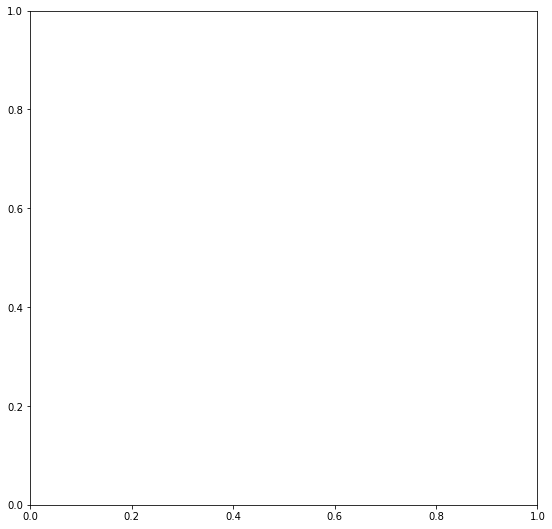

In [81]:
        if(type_of_pd_signal == 'sweep_power' or type_of_pd_signal == 'transferfunction_power'):#pd0で見る物はここ
            fig1 = plt.figure(figsize=(20,20))
            #fig1.suptitle('%s_DC'%(port))
            plot_types = ["pdoutput"]
            plotnum = len(port_trues)
            v_plotnum = math.ceil(math.sqrt(plotnum))
            h_plotnum = math.ceil(math.sqrt(plotnum))
            def loopvariables(i, k, j):
                return k
            def loopvariables_2(i, k, j):
                return k
        elif(type_of_pd_signal=='sweep_demod_1'):#pd1で見る物はここ
            fig1 = plt.figure(figsize=(20,20))
            plot_types = ["pdoutput"]
            #fig1.suptitle('absolute value')
            overplot_true = [ i for i in range(len(bool_overplots)) if bool_overplots[i] ]
            overplotnum = int(len(overplot_true)/2)
            plotnum = len(pdnames) - overplotnum
            v_plotnum = len(port_trues)
            h_plotnum = plotnum/v_plotnum
            def loopvariables(i, k, j):
                return k
            def loopvariables_2(i, k, j):
                return k
        elif(type_of_pd_signal=='transferfunction_demod_2'):#pd2で見る物はここ
            fig1 = plt.figure(figsize=(20,20))
            plot_types = ["pdoutput", "pdoutput_phase"]
            #fig1.suptitle('absolute value')
            overplot_true = [ i for i in range(len(bool_overplots)) if bool_overplots[i] ]
            overplotnum = int(len(overplot_true)/2)
            plotnum = (len(pdnames) - overplotnum)# (abs+phase)/2 ここはoutputの個数にした
            v_plotnum = 2*len(port_trues)#復調位相やオーバープロットした物を横に並べている
            h_plotnum = plotnum/(v_plotnum/2)#portは縦に並べている
            # gain
            def loopvariables(i, k1, j):
                k1 = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1
                return k1
            # phase
            def loopvariables_2(i, k2, j):
                k2 = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1+h_plotnum
                return k2
                
        def plottarget(j, plot_type):
            key = pdnames[j]
            target = out['%s' % key]
            label = "%s"%key
            if(plot_type=="pdoutput_phase"):
                target = np.angle(target)
                label = "%s_phase"%key
            return target, label

        # plot
        if Isoverplot_all_pds: # 全部overplotするとき
            plt.subplot(len(plot_types),1,1) #Axes
            for pdname in pdnames:
                label = "%s"%pdname
                plt.plot(out.x, out['%s' % pdname], label=label)
                plt.xscale(x_plotscale)
                plt.yscale(y_plotscale)
                plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                plt.title('%s' % plot_title, fontsize=18)
                plt.tick_params(labelsize=18)
                # 凡例の表示
                plt.legend(fontsize=18) # (yuzu) すべての凡例の大きさをxlabelとかと同じにしたほうが見栄えが良いしみやすい
            if "pdoutput_phase" in plot_types:
                plt.subplot(len(plot_types),1,2) #Axes
                for pdname in pdnames:
                    label = "%s_phase"%pdname
                    plt.plot(out.x, np.angle(out['%s' % pdname]), label=label)
                    plt.xscale(x_plotscale)
                    plt.yscale(y_plotscale)
                    plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                    plt.title('%s' % plot_title, fontsize=18)
                    plt.tick_params(labelsize=18)
                    # 凡例の表示
                    plt.legend(fontsize=18) # (yuzu) すべての凡例の大きさをxlabelとかと同じにしたほうが見栄えが良いしみやすい
            plt.show()
        else: # 全部overplotしないとき
            k,i,j,i_add,j_add = 1,0,0,h_plotnum,1
            while i < plotnum:
                h_i = 0#0に戻す
                plotpoint_pdoutput = loopvariables(i, k, j)
                plotpoint_pdoutput_phase = loopvariables_2(i, k, j)
                while h_i < h_plotnum: 
                    for plot_type in plot_types:
                        j_add = 1
                        if plot_type == "pdoutput_phase":
                            k = plotpoint_pdoutput_phase
                            color1,color2 = "darkorange","firebrick"
                        else:
                            k = plotpoint_pdoutput
                            color1,color2 = "seagreen","royalblue"

                        plt.subplot(v_plotnum,h_plotnum,k) #Axes

                        if bool_overplots[j] == True:
                            # IとQのoverplot
                            target, label = plottarget(j, plot_type)
                            plt.plot(out.x, target, label=label, color=color1)
                            target, label = plottarget(j+1, plot_type)
                            plt.plot(out.x, target, label=label, color=color2)
                            j_add = 2
                        else:
                            target, label = plottarget(j, plot_type)
                            plt.plot(out.x, target, label=label, color=color1)
                        plt.xscale(x_plotscale)
                        plt.yscale(y_plotscale)
                        plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                        plt.title('%s' % plot_title, fontsize=18)
                        plt.tick_params(labelsize=18)
                        # 凡例の表示
                        plt.legend(fontsize=18) # (yuzu) すべての凡例の大きさをxlabelとかと同じにしたほうが見栄えが良いしみやすい
                    j += j_add
                    k, plotpoint_pdoutput, plotpoint_pdoutput_phase, h_i = k+1, plotpoint_pdoutput+1, plotpoint_pdoutput_phase+1, h_i+1
                # loop
                i += i_add
                plt.tight_layout()
            plt.show()

In [ ]:
def make_katpdname(values, type_of_pd_signal):#values

    # １回しか使ってないので関数にしなくても良いかもしれない
    # fpmi_pd1_I_fsb1_REFL のようなpdの名前を作成してリストにする
    # このリストを使ってout.plotの部分を共通にしたり、選択したpdだけがkatファイルに追加されるようにする
    # pd1_I1_REFL のようなpdの名前を作成してリストにする
    # このリストを使ってout.plotの部分を共通にしたり、選択したpdだけがkatファイルに追加されるようにする

    interferometers = ["mi", "fpmi", "prfpmi", "drfpmi"]
    l_alpdstype = ["pd0", "pd1", "pd2"]
    l_all_demod_phase = ["overplot_IQ", "Iphase", "Qphase"]
    l_all_demod_freq = ["fsb1", "fsb2"]
    pdnames = []
    bool_overplots = []

    # pd1_fsb1_Iphase_REFLの順でpdの名前を作る
    if type_of_pd_signal == "sweep_power" or type_of_pd_signal == "transferfunction_power":
        for port in port_trues:
            pdnames.append("pd0_%s"%(port))
            bool_overplots.append(False)
    else:
        for interferometer in interferometers:
            for pdtype in l_alpdstype:
                for port in port_trues:
                    for freq in l_all_demod_freq:
                        for phase in l_all_demod_phase:
                            key = interferometer+"_%s_%s_%s" % (pdtype, phase, freq)#先頭にkを足すとGUIでのkeyになる
                            if ("k"+key in values and values["k"+key]):
                                if phase == "overplot_IQ":
                                    Isoverplot = True
                                    names = ["%s_Iphase_%s" % (pdtype, freq), "%s_Qphase_%s" % (pdtype, freq)]
                                else:
                                    Isoverplot = False
                                    names = ["%s_%s_%s" % (pdtype, phase, freq)]
                                for name in names:
                                    bool_overplots.append(Isoverplot)
                                    pdnames.append("%s_%s" % (name, port))

    # 戻り値が多い
    # いらないやつ l_katoverplotpdname l_katport l_katfreq l_katphase
    return pdnames, bool_overplots

In [ ]:
            plotnum = 0
            for port in port_trues:
                plotnum += 1 #plotnum
            if(plotnum > 0):
                i = 0
                inf_f_list_demon_phase = ['kfpmi_pd2_I_fsb1', 'kfpmi_pd2_Q_fsb1', 
                                            'kfpmi_pd2_overplot_IQ_fsb1', 
                                            'kfpmi_pd2_I_fsb2', 'kfpmi_pd2_Q_fsb2', 
                                            'kfpmi_pd2_plot_I_Q_overplot_f2'
                                            ]
                inf_f_list_demon_phase_name = ['pd2_I_fsb1', 'pd2_Q_fsb1', 
                                            'pd2_plot_I_Q_overplot_f1', 
                                            'pd2_I_fsb2', 'pd2_Q_fsb2', 
                                            'pd2_plot_I_Q_overplot_f2']
                inf_f_list_demon_phase_True = [k for k in inf_f_list_demon_phase if values[k] == True]
                j = len(inf_f_list_demon_phase_True)
                print('j'+str(j))
                if(j==0):
                    values['kfpmi_pd2_I_fsb1'] = True
                    j = 1
                #plotの横の数
                h_plotnum = j
                #plotの縦の数
                v_plotnum = 2*plotnum
                for port in port_trues:
                    k = math.floor((i/h_plotnum))*2*h_plotnum + i%h_plotnum+1
                    for l in range(len(inf_f_list_demon_phase)):
                        if (values[inf_f_list_demon_phase[l]]==True):
                            # abs
                            plt.subplot(v_plotnum,h_plotnum,k) #Axes

                            if(inf_f_list_demon_phase[l]=='kfpmi_pd2_overplot_IQ_fsb1'):
                                plt.plot(out.x, out['pd2_I_fsb1_%s' % (port)], label='pd2_I_fsb1__%s_abs' % (port), color = '#377eb8')
                                plt.plot(out.x, out['pd2_Q_fsb1_%s' % (port)], label='pd2_Q_fsb1__%s_abs' % (port), color = '#4daf4a')
                            elif(inf_f_list_demon_phase[l]=='kfpmi_pd2_plot_I_Q_overplot_f2'):
                                plt.plot(out.x, out['pd2_I_fsb2_%s' % (port)], label='pd2_I_fsb2__%s_abs' % (port), color = '#377eb8')
                                plt.plot(out.x, out['pd2_Q_fsb2_%s' % (port)], label='pd2_Q_fsb2__%s_abs' % (port), color = '#4daf4a')
                            else:
                                plt.plot(out.x, out['%s_%s' % (inf_f_list_demon_phase_name[l], port)], label='%s_%s_abs' % (inf_f_list_demon_phase_name[l], port), color = '#377eb8')
                            plt.xscale(x_plotscale)
                            plt.yscale(y_plotscale)
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()

                            # phase
                            plt.subplot(v_plotnum,h_plotnum,k+h_plotnum) #Axes
                            if(inf_f_list_demon_phase[l]=='kfpmi_pd2_overplot_IQ_fsb1'):
                                plt.plot(out.x, np.angle(out['pd2_I_fsb1_%s' % (port)]), label='pd2_I_fsb1__%s_phase' % (port), color = '#377eb8')
                                plt.plot(out.x, np.angle(out['pd2_Q_fsb1_%s' % (port)]), label='pd2_Q_fsb1__%s_phase' % (port), color = '#4daf4a')
                            elif(inf_f_list_demon_phase[l]=='kfpmi_pd2_plot_I_Q_overplot_f2'):
                                plt.plot(out.x, np.angle(out['pd2_I_fsb2_%s' % (port)]), label='pd2_I_fsb2__%s_phase' % (port), color = '#377eb8')
                                plt.plot(out.x, np.angle(out['pd2_Q_fsb2_%s' % (port)]), label='pd2_Q_fsb2__%s_phase' % (port), color = '#4daf4a')
                            else:
                                plt.plot(out.x, np.angle(out['%s_%s' % (inf_f_list_demon_phase_name[l], port)]), label='%s_%s_phase' % (inf_f_list_demon_phase_name[l], port), color = 'firebrick')
                            plt.xscale(x_plotscale)
                            plt.yscale(y_plotscale)
                            plt.xlabel(out.xlabel.split()[0]+out.xlabel.split()[1], fontsize=18)
                            plt.title('%s' % plot_title, fontsize=18)
                            plt.tick_params(labelsize=18)
                            # 凡例の表示
                            plt.legend()
                            k += 1
                    i += j

In [ ]:
#
# 1回しか使ってないから関数にしなくてもいいと思った
#
# port_trues: 選んだノードのリスト REFL, AS...
# いらなかった　port_trues_name: 選んだポートの名前のリスト　kFPMI_REFL, kFPMI_AS...　
# pds_true_name: 選んだpdの名前のリスト 'fpmi_REFL_fpmi_pd1_Q1', 'fpmi_REFL_fpmi_pd1_Q2', 'fpmi_AS_fpmi_pd1_Q1', 'fpmi_AS_fpmi_pd1_Q2'] これを使ってkatファイルを作成すれば選択したPDだけ書き込めると思ったけどできなかった
#

def make_common_config(values):
    interferometers = ["MI", "FPMI", "PRFPMI", "DRFPMI"]
    l_all_port = ["REFL", "AS", "nTMSX", "nTMSY", 
                    "n2", "n3", # n1=REFL, n4=AS
                    "nx1", "nx2", "nx3",
                    "ny1", "ny2", "ny3"]
    l_all_demod_phase = []
    port_trues = []
    l_port_name = []
    for interferometer in interferometers:
        for port in l_all_port:
            port_name = "%s_%s" % (interferometer, port)
            if "k"+port_name in values:# valueにはGUIのチェックボックスのkFPMI_REFLなどが入っている
                l_port_name.append(port_name) # portのkeyの名前　kFPMI_REFL　などができた
                if(values["k"+port_name]):
                    port_trues.append(port)

    
    port_trues_name = [port for port in l_port_name if values["k"+port] == True]

    return port_trues

In [ ]:
i = 0
while i < 10:
    print(i)
    if i == 5:
        i += 2
    else:
        i += 1

In [ ]:
type_test = 2
if type_test == 1:
    a = 1
    b = 2
    c = 3
    def test(a,b,c):
        return a,b,c
elif type_test == 2:
    a = 1
    b = 2
    c = 3
    def test(a,b,c):
        b = a+b+c
        return a,b,c
a,b,c = test(a,b,c)
print(a)
print(b)
print(c)


In [ ]:
a,b,c = 5,6,7
for i in range(4):
    a,b,c = a+1,b+2,c+3
    print(b)

In [ ]:
names = ["aaa", "bbb"]
for n in range(len(names)):
    print(n)

In [37]:
fname_plotdata = sg.popup_get_file('Select the output name for plot data?', save_as=True, file_types=(("ALL Files", "*.txt"),))

f = open(fname_plotdata, 'x')
pdnames = ["REFL","AS","POP"]
content1 = [1,2,3,4,5]
content2 = [6,7,8,9,10]
content3 = [11,12,13,14,15]
content = {
        'REFL':content1,
        'AS':content2,
        'POP':content3,
}
pdnames = set(pdnames)

import datetime
dt_now = datetime.datetime.now()
header_file = "# This is finesse result simulated at %s \n# x " % dt_now
arr = np.empty((0, content.size), float)
arr = np.append(arr, content, axis=0)
# overplot用に重複しているものをなくす
# プロットの表示と違って順番関係ないと思うからとりあえずset()を使うことにする
# out['%s' % pdnames[j]]
# arr = np.append(arr, [out[pdname], axis=0)
#
for pdname in pdnames:
    arr = np.append(arr, content[pdname], axis=0)
    header_file += pdname+" "
L = np.asarray(arr).T
x=L.tolist()
plotdata=[" ".join(map(str, i)) for i in x]
#print(plotdata)
f.writelines(header_file + '\n')
for i in plotdata:
    f.writelines(i)
    f.write('\n')
f.close()          

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [4]:
testword = "AAA"
list = ["aaa_%s_bbb"%testword, "aaa_%s"%testword]

print(list)

['aaa_AAA_bbb', 'aaa_AAA']


In [17]:
text = '\n'.join([str(i) for i in range(10)])
font = ("Courier New", 15)
layout = [
    [sg.Column([[sg.Text(text, font=font)]], size=(245, 115), scrollable=True)]
]
window = sg.Window("test", layout, margins=(0, 0), finalize=True)

while True:
    event, values = window.read()
    if event is None or event == 'Exit':
        break
window.close()